# Randomization Unit

This notebook will compare the chosen user based randomization with two other possibilities: event and session 

In [2]:
from __future__ import annotations
from IPython import get_ipython
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn.linear_model import LinearRegression
from statsmodels.stats.power import tt_ind_solve_power

In [3]:
base_path = os.path.abspath('')

events_df = pd.read_csv(f"{base_path}/Data/events_complete.csv")
events_df = events_df[(events_df["date"]).between("2020-01-01", "2020-02-31")]

events_df.replace({True: 1, False: 0}, inplace=True)
events_df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,time,date,sales,event_type_cart,event_type_purchase,event_type_remove_from_cart,event_type_view
12271406,2020-01-01 00:00:00 UTC,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a,2020-01-01 00:00:00+00:00,2020-01-01,0.0,0,0,0,1
12271407,2020-01-01 00:00:09 UTC,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a,2020-01-01 00:00:09+00:00,2020-01-01,0.0,0,0,0,1
12271408,2020-01-01 00:00:19 UTC,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,2020-01-01 00:00:19+00:00,2020-01-01,0.0,0,0,0,1
12271409,2020-01-01 00:00:24 UTC,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711,2020-01-01 00:00:24+00:00,2020-01-01,0.0,0,0,0,1
12271410,2020-01-01 00:00:25 UTC,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb,2020-01-01 00:00:25+00:00,2020-01-01,0.0,0,0,0,1


Plot the distributions of events/sessions per user and the convertions (has_purchase) vs that

In [4]:
events_df["event_type_purchase"].sum()

505790

In [5]:
events_df["user_session"].nunique()

1891452

In [6]:
events_df["event_type_purchase"].sum() / events_df["user_session"].nunique()

0.26740831911145513

In [8]:
events_df["event_type_purchase"].sum() / events_df["user_id"].nunique()

0.6861956361001936

In [14]:
agg_ussers = (
    events_df
    .groupby("user_id")
    .agg({
        "product_id":   "count",
        "user_session": "nunique",
        "event_type_purchase": "sum",
    })
).reset_index()

agg_ussers.columns = ["user_id", "events", "sessions", "n_purchases"]
agg_ussers

,user_id,events,sessions,n_purchases
0,465496,3,2,0
1,2038666,1,1,0
2,3571443,2,1,0
3,4230352,1,1,0
4,4661182,20,6,0
...,...,...,...,...
737088,622090016,2,2,0
737089,622090043,3,1,0
737090,622090052,2,2,0
737091,622090098,1,1,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


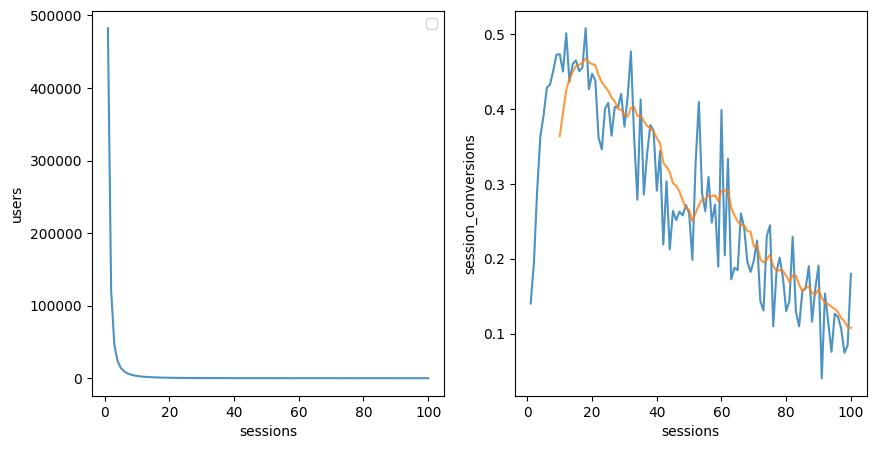

In [28]:
sessions_per_user = (
    agg_ussers
    .groupby("sessions")
    .agg({
        "user_id":      "count",
        "n_purchases":  "sum",
    })
).reset_index()
sessions_per_user.columns = ["sessions", "users", "n_purchases"]
sessions_per_user["purchases_per_user"] = sessions_per_user["n_purchases"] / sessions_per_user["users"]
sessions_per_user["session_conversions"] = sessions_per_user["purchases_per_user"] / sessions_per_user["sessions"]
sessions_per_user['session_conversions_ma'] = sessions_per_user['session_conversions'].rolling(10).mean()


fig, ax = plt.subplots(1,2, figsize=(10, 5))
sns.lineplot(sessions_per_user[sessions_per_user["sessions"].between(1,100)], x="sessions", y="users", ax=ax[0], alpha=0.8)
sns.lineplot(sessions_per_user[sessions_per_user["sessions"].between(1,100)], x="sessions", y="session_conversions", ax=ax[1], alpha=0.8)
sns.lineplot(sessions_per_user[sessions_per_user["sessions"].between(1,100)], x="sessions", y="session_conversions_ma", ax=ax[1], alpha=0.8)

ax[0].legend()